# Importing the Keras libraries and packages

In [1]:
# Import TensorFlow & Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2024-09-25 23:24:34.930480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 23:24:34.950220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 23:24:34.956023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 23:24:34.971733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import the Fashion MNIST dataset

In [2]:
dataset, metadata = tfds.load("fashion_mnist", as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

I0000 00:00:1727295880.368620   14045 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727295880.376822   14045 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727295880.377021   14045 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727295880.382651   14045 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727295880.382750   14045 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images

In [3]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Explore the data

In [4]:
num_train_examples = metadata.splits["train"].num_examples
num_test_examples = metadata.splits["test"].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


# Preprocess the data

In [5]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label


train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Explore the processed data

2024-09-25 23:24:41.577814: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-25 23:24:41.578366: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


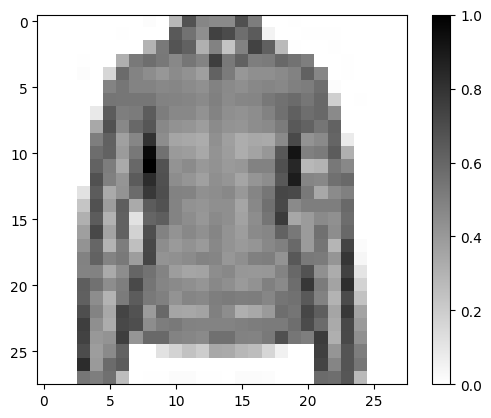

In [6]:
for image, label in test_dataset.take(1):
    image = image.numpy().reshape((28, 28))
    break

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

2024-09-25 23:24:42.579483: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-25 23:24:42.579737: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-25 23:24:42.591575: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

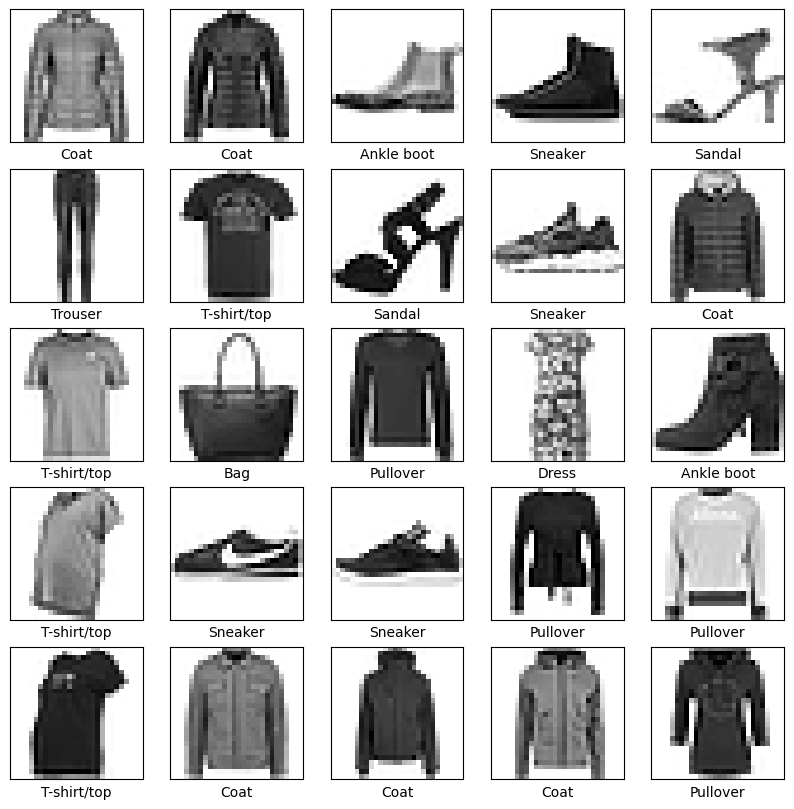

In [7]:
plt.figure(figsize=(10, 10))
i = 0
for image, label in test_dataset.take(25):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# Build the model

In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            input_shape=(28, 28, 1),
        ),
        tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

/home/omar/miniconda3/envs/.tf217/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile Model

In [9]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"],
)

# Train the model

In [10]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [11]:
# Check if GPU is being used
with tf.device("/GPU:0"):
    model.fit(
        train_dataset,
        epochs=10,
        steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE),
    )

Epoch 1/10


I0000 00:00:1727295889.178595   14115 service.cc:146] XLA service 0x7f6570005280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727295889.178640   14115 service.cc:154]   StreamExecutor device (0): Quadro T2000, Compute Capability 7.5
2024-09-25 23:24:49.207883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-25 23:24:49.514222: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  33/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3710 - loss: 1.7094

I0000 00:00:1727295892.665527   14115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7989 - loss: 0.5504
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8992 - loss: 0.2722
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9230 - loss: 0.2180
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9319 - loss: 0.1854
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9419 - loss: 0.1562
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9494 - loss: 0.1334
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9612 - loss: 0.1075
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9636 - loss: 0.0968
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9697 - loss: 0.0806
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9759 - loss: 0.0672


# Evaluate accuracy

In [12]:
test_loss, test_accuracy = model.evaluate(
    test_dataset, steps=math.ceil(num_test_examples / 32)
)
print("Accuracy on test dataset:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9227 - loss: 0.2989
Accuracy on test dataset: 0.9225000143051147


# Make predictions and explore

In [13]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


2024-09-25 23:28:21.009061: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
predictions.shape

(32, 10)

In [15]:
predictions[0]

array([1.4451168e-12, 2.2915574e-10, 4.3516618e-08, 3.4832494e-13,
       9.0073866e-01, 1.4424125e-12, 9.9261284e-02, 5.6538907e-14,
       2.5741240e-14, 1.0517551e-08], dtype=float32)

In [16]:
np.argmax(predictions[0])

4

In [17]:
test_labels[0]

4

In [18]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[predicted_label],
            100 * np.max(predictions_array),
            class_names[true_label],
        ),
        color=color,
    )


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

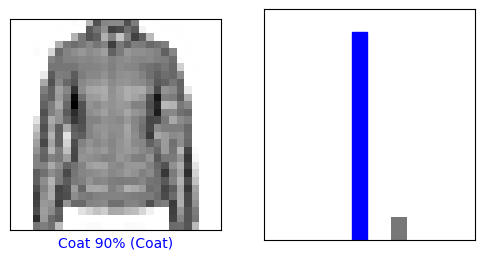

In [19]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

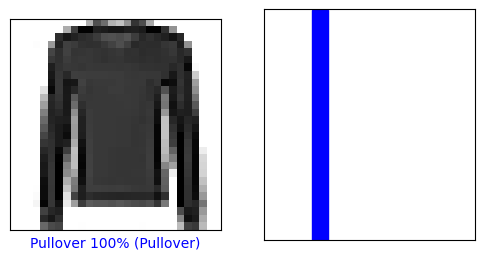

In [20]:
i = 12
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

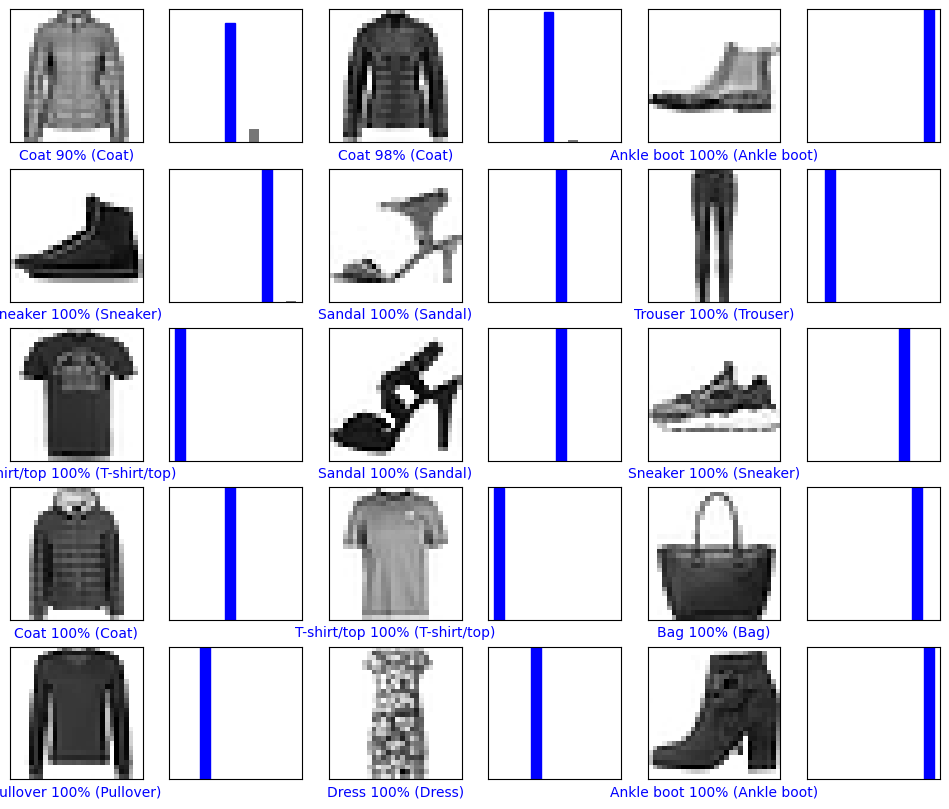

In [21]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, test_labels)

# Grab an image from the test dataset

In [22]:
img = test_images[0]

print(img.shape)

(28, 28, 1)
